In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans #for kmeans algorithm

#For dimensionality reduction.
from sklearn.decomposition import PCA #pca from decomposition module.
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition #decomposition module
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sn

In [2]:
# Loading the data
# Loading Aisles data into Aisles
aisles = pd.read_csv('aisles.csv')

# Loading Departments data into Departments
departments = pd.read_csv('departments.csv')

# Loading Training order data into orderProductsTrain
orderProductsTrain = pd.read_csv('order_products__train.csv')

# Loading the Orders into Orders
orders = pd.read_csv('orders.csv')

# Loading Products data into Products
products = pd.read_csv('products.csv')

# Loading Prior order data into orderProductsPrior
orderProductsPrior = pd.read_csv('order_products__prior.csv')

In [3]:
#Out of all the dataframes, orders dataset has some null values. We will drop these values from our dataset.
#checking if dfs have nulls one by one
aisles.isnull().sum()
departments.isnull().sum()
products.isnull().sum()
orderProductsPrior.isnull().sum()
orderProductsTrain
orders.isnull().sum() # orders dataset has some nulls. We will drop them.

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [4]:
orders.dropna(inplace=True)


In [5]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0


In [6]:
#Here we have merged the orderProductsPrior and the orders on the order_id to show which user ordered what products and in what order
#combine data frames on primary and foreign keys. 
df1 = pd.merge(orderProductsPrior, orders, on= 'order_id')
df1.head(2)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0


In [7]:
#Here we have merged the aisles and the products

prod_aisles = pd.merge(products, aisles, on = 'aisle_id')
df2 = pd.merge(prod_aisles, departments, on = 'department_id')
df2.head(2)

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,cookies cakes,snacks


In [8]:
# Here we are combing both the data frames we created above on prod_id
combined_df = pd.merge(df1, df2, on = 'product_id').reset_index(drop=True)
combined_df.head(2)
combined_df.shape

(30356421, 15)

In [9]:
#Here we have created the crosstab using the user_id and the aisle
user_by_aisle_df = pd.crosstab(combined_df['user_id'], combined_df['aisle'])
user_by_aisle_df.head(2)
user_by_aisle_df.shape

(206209, 134)

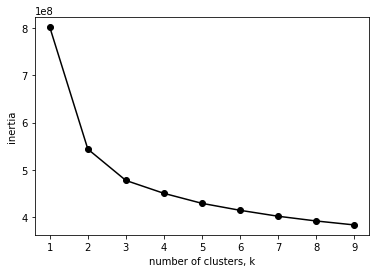

In [10]:
#Using Elbow Method
X = user_by_aisle_df.values
user_by_aisle_df.head()


#Implementing the Elbow method to identify the ideal value of 'k'. 

ks = range(1,10) #here we have selected the range for k from 1 to 10
inertias = []
for k in ks:
    model = KMeans(n_clusters=k)    # Create a KMeans instance with k clusters: model
    model.fit(X)                    # Fit model to samples
    inertias.append(model.inertia_) # Append the inertia to the list of inertias
    
plt.plot(ks, inertias, '-o', color='black') #Plotting. The plot will give the 'elbow'.
plt.xlabel("number of clusters, k")
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [11]:
#Decomposing the features into 5 using PCA (seeing the above plot, n_components = 5)
pca = decomposition.PCA(n_components=5)
pca_user_order = pca.fit_transform(X)

In [12]:
#Checking the % variation explained by the 5 pca components.
pca.explained_variance_ratio_.sum()

0.7001789536856414

Text(0, 0.5, 'variance %')

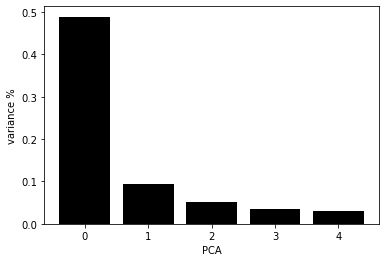

In [13]:
# Plot the explained variances to verify the variation.
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA')
plt.ylabel('variance %')

In [14]:
#Model K-mean
PCA_components = pd.DataFrame(pca_user_order)
PCA_components.head(5)

,0,1,2,3,4
0,-22.507005,2.436471,-2.431904,0.007773,0.289820
1,5.818795,35.590422,10.148410,15.261575,-6.805824
2,-9.491096,1.164906,-8.336592,0.169031,-0.215276
3,-26.359757,-0.825700,-1.933159,2.552823,-0.177053
4,-21.483427,-1.337097,-0.412182,3.015696,0.612411


In [15]:
kmeans = KMeans(n_clusters=5)
X_clustered = kmeans.fit_predict(pca_user_order)

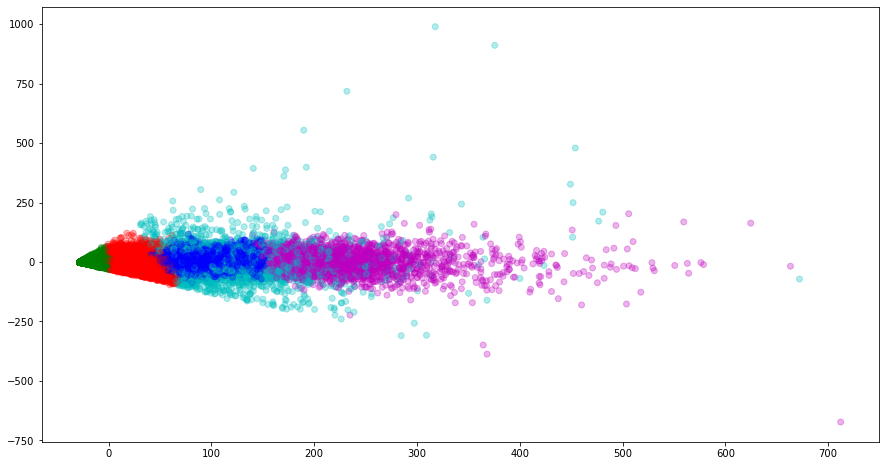

In [16]:
#mapping all the user_id's to their repective clusters
label_color_mapping = {0:'r', 1: 'g', 2: 'b',3:'c' , 4:'m'}
label_color = [label_color_mapping[l] for l in X_clustered]

#Scatterplot showing the cluster to which each user_id belongs.
plt.figure(figsize = (15,8))
plt.scatter(pca_user_order[:,0],pca_user_order[:,2], c= label_color, alpha=0.3) 
plt.xlabel = 'X-Values'
plt.ylabel = 'Y-Values'
plt.show()

In [17]:
#Mapping clusters to users.
user_by_aisle_df['cluster']=X_clustered

In [18]:
#Checking cluster concentration. 
user_by_aisle_df['cluster'].sort_values(ascending = False)

user_id
133949    4
134482    4
83178     4
31773     4
31760     4
         ..
29764     0
29763     0
90038     0
74450     0
103105    0
Name: cluster, Length: 206209, dtype: int32

In [19]:
#The cluster mapping.
user_by_aisle_df.head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,0,3,0,0,0,0,2,0,0,0,...,1,1,0,0,0,0,2,0,42,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,2,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
5,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,1
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,4,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,2,0,14,1


In [20]:
c0 = user_by_aisle_df[user_by_aisle_df['cluster']==0].drop('cluster',axis=1).mean()
c1 = user_by_aisle_df[user_by_aisle_df['cluster']==1].drop('cluster',axis=1).mean()
c2 = user_by_aisle_df[user_by_aisle_df['cluster']==2].drop('cluster',axis=1).mean()
c3 = user_by_aisle_df[user_by_aisle_df['cluster']==3].drop('cluster',axis=1).mean()
c4 = user_by_aisle_df[user_by_aisle_df['cluster']==4].drop('cluster',axis=1).mean()
c5 = user_by_aisle_df[user_by_aisle_df['cluster']==5].drop('cluster',axis=1).mean()

In [21]:
user_by_aisle_df.pivot_table(index='cluster',aggfunc='count')

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
cluster,,,,,,,,,,,,,,,,,,,,,
0,38699,38699,38699,38699,38699,38699,38699,38699,38699,38699,...,38699,38699,38699,38699,38699,38699,38699,38699,38699,38699
1,149664,149664,149664,149664,149664,149664,149664,149664,149664,149664,...,149664,149664,149664,149664,149664,149664,149664,149664,149664,149664
2,11425,11425,11425,11425,11425,11425,11425,11425,11425,11425,...,11425,11425,11425,11425,11425,11425,11425,11425,11425,11425
3,3615,3615,3615,3615,3615,3615,3615,3615,3615,3615,...,3615,3615,3615,3615,3615,3615,3615,3615,3615,3615
4,2806,2806,2806,2806,2806,2806,2806,2806,2806,2806,...,2806,2806,2806,2806,2806,2806,2806,2806,2806,2806


In [22]:
# to find the aisles from which the customers are buying most. We have done this in order to identify the kind of customers from each cluster. And we will do that individually
c0.sort_values(ascending=False)[0:20]

aisle
fresh fruits                     28.883589
fresh vegetables                 25.465878
packaged vegetables fruits       14.093362
yogurt                           11.729192
packaged cheese                   7.853019
milk                              7.171632
water seltzer sparkling water     6.915347
chips pretzels                    5.958655
soy lactosefree                   5.214062
refrigerated                      4.783121
bread                             4.670508
frozen produce                    4.228145
ice cream ice                     4.042301
energy granola bars               3.832657
crackers                          3.716737
eggs                              3.674591
lunch meat                        3.208843
frozen meals                      3.134939
cereal                            3.043412
baby food formula                 2.966640
dtype: float64

In [23]:
c1.sort_values(ascending=False)[0:20]

aisle
fresh fruits                     5.041847
fresh vegetables                 4.658067
packaged vegetables fruits       2.735207
yogurt                           2.228478
water seltzer sparkling water    1.966398
packaged cheese                  1.778464
milk                             1.574246
chips pretzels                   1.543738
ice cream ice                    1.208146
soft drinks                      1.155515
soy lactosefree                  1.133258
refrigerated                     1.130907
bread                            1.097077
frozen meals                     1.037310
frozen produce                   0.941756
crackers                         0.933037
packaged produce                 0.884114
eggs                             0.857387
cereal                           0.841819
energy granola bars              0.799451
dtype: float64

In [24]:
c2.sort_values(ascending=False)[0:20]

aisle
fresh vegetables                 77.944683
fresh fruits                     62.705908
packaged vegetables fruits       31.674311
yogurt                           17.614530
packaged cheese                  14.694705
milk                             12.633873
soy lactosefree                  10.160700
water seltzer sparkling water     9.094880
fresh herbs                       8.860832
frozen produce                    8.654617
bread                             8.594573
chips pretzels                    8.260656
eggs                              7.518249
refrigerated                      7.398425
ice cream ice                     5.931991
lunch meat                        5.724289
crackers                          5.673786
canned jarred vegetables          5.634311
baby food formula                 5.555974
soup broth bouillon               5.387046
dtype: float64

In [25]:
c3.sort_values(ascending=False)[0:20]

aisle
fresh fruits                     116.795851
yogurt                            73.764592
packaged vegetables fruits        41.832365
fresh vegetables                  39.417427
milk                              29.676072
packaged cheese                   26.899032
water seltzer sparkling water     24.618811
chips pretzels                    21.619917
baby food formula                 20.327801
energy granola bars               20.314246
refrigerated                      18.018257
soy lactosefree                   16.368741
bread                             15.708437
crackers                          13.396957
cereal                            11.400553
lunch meat                        11.142739
frozen produce                    10.193638
fresh dips tapenades              10.008299
tea                                9.643430
cream                              9.511203
dtype: float64

In [26]:
c4.sort_values(ascending=False)[0:20]

aisle
fresh vegetables                 173.493942
fresh fruits                     148.009979
packaged vegetables fruits        66.655025
yogurt                            38.057377
packaged cheese                   28.930150
milk                              27.046329
fresh herbs                       18.861368
soy lactosefree                   18.725944
bread                             17.052388
frozen produce                    16.490021
chips pretzels                    14.702780
baby food formula                 14.501069
water seltzer sparkling water     13.292231
eggs                              12.856736
refrigerated                      12.754811
crackers                          11.539914
lunch meat                        10.495367
canned jarred vegetables          10.374911
baking ingredients                10.109052
energy granola bars                9.828582
dtype: float64